In [6]:
curr_loss = 0
val_loss = 100
for epoch in range(100):
    net.train()
    for idx, data in enumerate(text_dataloader,0):
        inputs, labels = data
        inputs = inputs.type(torch.cuda.FloatTensor).transpose(0,1)
        labels = labels.type(torch.cuda.LongTensor)
        optimizer.zero_grad()
    
        outputs = net(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
    
        loss.backward()
        curr_loss += loss.item()
    
        optimizer.step()
    
        if idx % 100 == 99:
        
            loss_history.append(curr_loss / 100)
            loss_iter_history.append(loss_curr_iter)
            loss_curr_iter += 1
        
            loss_axis.lines[0].set_xdata(loss_iter_history)
            loss_axis.lines[0].set_ydata(loss_history)
        
            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
            print(idx + 1, curr_loss / 100)
            
            curr_loss = 0
    net.eval()
    for idx, data in enumerate(val_dataloader, 0):
        inputs, labels = data
        inputs = inputs.type(torch.cuda.FloatTensor).transpose(0,1)
        labels = labels.type(torch.cuda.LongTensor)
        outputs = net(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        curr_loss += loss.item()
    mean_loss = curr_loss / len(val_dataloader)
    
    if mean_loss < val_loss:
        val_loss = mean_loss
        print(mean_loss)
        torch.save(net.state_dict(), '/home/max/text_generation_with_rnn/Ed_Sheeran_lyrics_gen_dropout_0.25.pth')
    #print(loss.item())
    

100 3.69399194002
200 3.31067073584
300 3.14681852341
400 3.19218219042
500 3.19315357685
600 3.27369235754
700 3.10149174929
800 3.17292672396
900 3.18248151779
1000 3.190426054
1100 3.14218159914
1200 3.16166927576
1300 3.07687659502
1400 3.22509829998
1500 3.09974653959
1600 3.23352822065
1700 3.20071094036
1800 3.21679648876
1900 3.07181325674
2000 3.09140258312
2100 3.11318139553
2200 3.17535898924
2300 3.26757624865
2400 3.11998369932
2500 3.16631921291
2600 3.17460237741
2700 3.09678163528
2800 3.15672820807
2900 3.13820577741
3000 3.00384259939
3100 3.08098440528
3200 3.06591181874
3300 2.99067757845
3400 2.99403914452
3500 2.94015142322
3600 3.04062752724
3700 2.82185810804
3800 2.84521736622
3900 2.88876481414
4000 2.93403366685
4100 2.92444994807
4200 2.96187091947
4300 2.77721732378
4400 2.88860969543
4500 2.79793466091
4600 3.09014680624
4700 2.91688835502
4800 2.75428695738
4900 2.7489677906
5000 2.9502506566
5100 2.75194178343
5200 2.75518136442
5300 2.69229767203
5400 2

1500 1.78355189443
1600 1.66421787679
1700 1.82558564037
1800 1.78947746813
1900 1.70917678535
2000 1.68217669964
2100 1.83656805515
2200 1.60976920485
2300 1.74599470079
2400 1.81001172841
2500 1.73907642484
2600 1.77305749059
2700 1.70027278364
2800 1.72661138356
2900 1.69967538059
3000 1.85407836139
3100 1.81506673157
3200 1.92379770994
3300 1.7224303937
3400 1.74588350773
3500 1.8592287761
3600 1.83065937042
3700 1.65578141451
3800 1.67948926866
3900 1.72776962578
4000 1.80880386055
4100 1.74308113933
4200 1.79073092461
4300 1.80322003186
4400 1.84966205478
4500 1.75127314746
4600 1.64829923749
4700 1.85238927364
4800 1.75304166138
4900 1.7399737519
5000 1.68733653009
5100 1.74020375252
5200 1.78795690984
5300 1.72388405681
5400 1.74167729616
5500 1.72923344851
5600 1.69210487604
5700 1.71368181348
5800 1.68785787106
5900 1.90676220238
6000 1.71082480073
100 65.7928103954
200 1.65893191457
300 1.77775216162
400 1.6080843854
500 1.66597949743
600 1.67021980762
700 1.63284227163
800 

3200 1.44215074778
3300 1.3468773514
3400 1.49636247635
3500 1.34219605684
3600 1.65070228338
3700 1.43464383721
3800 1.53815067172
3900 1.50665775806
4000 1.38671822667
4100 1.31805811822
4200 1.55401956379
4300 1.36856302261
4400 1.41462451637
4500 1.46461639702
4600 1.44272370309
4700 1.44314026445
4800 1.36579162151
4900 1.48895335466
5000 1.35241121471
5100 1.41968894571
5200 1.29141676337
5300 1.41576855838
5400 1.3840210095
5500 1.40058482647
5600 1.34192520648
5700 1.46743326396
5800 1.58662789285
5900 1.36134473294
6000 1.47811672926
100 63.003677128
200 1.4689973402
300 1.48674482107
400 1.44842588723
500 1.41815045416
600 1.48416926086
700 1.47317319751
800 1.21119778961
900 1.39509699315
1000 1.30668973446
1100 1.37766859055
1200 1.40242708981
1300 1.4105806607
1400 1.18017805874
1500 1.52385760546
1600 1.29012209207
1700 1.35081560791
1800 1.43841248631
1900 1.47724494278
2000 1.42405465841
2100 1.2016435647
2200 1.42900210083
2300 1.56068528533
2400 1.45795709193
2500 1.3

4900 1.28419921875
5000 1.39425114691
5100 1.3168630898
5200 1.29875436693
5300 1.16824697256
5400 1.33214482844
5500 1.09676375479
5600 1.06828666687
5700 1.28593016684
5800 1.30383300841
5900 1.25843989462
6000 1.1628932777
100 70.6389179698
200 1.11641848832
300 1.07536217704
400 1.04976673573
500 1.08464452147
600 1.19844013691
700 1.05287450075
800 1.18215545535
900 1.31151242405
1000 1.31297386467
1100 1.14667792946
1200 1.21268912435
1300 1.18780347735
1400 1.22793557346
1500 1.06895213366
1600 1.18121871412
1700 1.11825699806
1800 1.24115300864
1900 1.0505910185
2000 1.25557302713
2100 1.34149818897
2200 1.27877412677
2300 1.10784900665
2400 0.99184923172
2500 1.26280779213
2600 1.17729239166
2700 1.15563902199
2800 1.12293427885
2900 1.13814324141
3000 1.1663028717
3100 1.05849791825
3200 1.21035106212
3300 1.37359065354
3400 1.24219417185
3500 1.24984010756
3600 1.27976326078
3700 1.25317755282
3800 1.02700813174
3900 1.21144923657
4000 1.14663458675
4100 1.20946512669
4200 1

400 0.984456292391
500 0.882646319866
600 0.95912222445
700 0.97981658116
800 1.04574741602
900 0.951928285956
1000 0.945175484717
1100 0.899531745315
1200 1.1020950672
1300 1.01865950167
1400 1.0699710831
1500 0.933576310277
1600 0.968271348029
1700 0.900944427848
1800 0.973386616409
1900 1.00024046183
2000 0.941143237948
2100 0.965348584056
2200 1.14258610487
2300 1.06232757032
2400 1.07737787336
2500 1.08237578809
2600 0.890801691413
2700 1.02852195926
2800 1.07124619275
2900 1.08135874867
3000 1.00719030529
3100 1.09687576592
3200 1.12423712283
3300 1.05726170391
3400 1.12737734735
3500 1.13372971117
3600 1.02054941326
3700 1.15161695197
3800 0.909647600949
3900 1.02138669044
4000 1.11440170884
4100 1.130013493
4200 1.21345185906
4300 1.02042917252
4400 1.16780754089
4500 1.05865577489
4600 0.993126374781
4700 1.15342936933
4800 0.996095569432
4900 1.04112436682
5000 1.07560733825
5100 0.973980171829
5200 0.951113807559
5300 1.04928103089
5400 1.25556244001
5500 1.04186217427
5600 

800 0.833872816861
900 0.831946175694
1000 0.877512757778
1100 0.839834376872
1200 0.94889097169
1300 0.947128100395
1400 0.909320966899
1500 0.896858717501
1600 1.04202286229
1700 0.935477265269
1800 0.860012139603
1900 0.762217734754
2000 0.956183308214
2100 1.09747300379
2200 0.962052141428
2300 0.886231559813
2400 0.802584643364
2500 0.918728123903
2600 0.911781687587
2700 0.943257517219
2800 0.985687590465
2900 0.822589296997
3000 0.986111771464
3100 1.05893803105
3200 0.949807666242
3300 0.919018958658
3400 1.1157905671
3500 0.833983704448
3600 0.87654636696
3700 0.896130624413
3800 0.857807223946
3900 0.839783783555
4000 0.861318057179
4100 0.897851849347
4200 0.964017392844
4300 0.813637647405
4400 0.950531475544
4500 0.841608894467
4600 1.03891815275
4700 0.824837327078
4800 0.87395465225
4900 0.888914206475
5000 0.94236322403
5100 0.897362902164
5200 0.918993807733
5300 0.966360020638
5400 1.02296591103
5500 0.926624129564
5600 0.915817082822
5700 0.875708334744
5800 0.821820

600 0.907914519757
700 0.749563566297
800 0.725624401569
900 0.780965235382
1000 0.835300966501
1100 0.812555206269
1200 0.746110680401
1300 0.704931256622
1400 0.905651672184
1500 0.748304322362
1600 0.726459515989
1700 0.834119759351
1800 0.835554298237
1900 0.874058613777
2000 0.803480018973
2100 0.807559650242
2200 0.865408271849
2300 0.723179728687
2400 0.894444263577
2500 0.878029228449
2600 0.733363861591
2700 0.8356179519
2800 0.794974609017
2900 0.770235380977
3000 0.717911020517
3100 0.895087225735
3200 0.888221897036
3300 0.843046316504
3400 0.854216587394
3500 0.769827866703
3600 0.932798138857
3700 0.802969234884
3800 0.887721757293
3900 0.967773095369
4000 0.664968869835
4100 0.866854472756
4200 0.823821676672
4300 0.735189114958
4400 0.950239198506
4500 0.85610808298
4600 0.854230107963
4700 0.865418450162
4800 0.799947546571
4900 0.82441931203
5000 0.924302761853
5100 0.879895905107
5200 0.927657684311
5300 0.908214080036
5400 0.90765155986
5500 0.887900454104
5600 0.93

100 90.6095557105
200 0.688055128157
300 0.630842160732
400 0.669814297259
500 0.757493172586
600 0.765737994015
700 0.757503293902
800 0.623698837161
900 0.720637995005
1000 0.813519556001
1100 0.872434741557
1200 0.734377849698
1300 0.712679904699
1400 0.663076805025
1500 0.685404293239
1600 0.772467973754
1700 0.679026710093
1800 0.753643752635
1900 0.730383611172
2000 0.666620121505
2100 0.668107984364
2200 0.723620560467
2300 0.751617756784
2400 0.716454415917
2500 0.595068532936
2600 0.739117094129
2700 0.75190361388
2800 0.751165795438
2900 0.740636279434
3000 0.754050055742
3100 0.773313460648
3200 0.894973375425
3300 0.748126954362
3400 0.84630415231
3500 0.760484294631
3600 0.765986691639
3700 0.746179767847
3800 0.793005843684
3900 0.770385662317
4000 0.786074772179
4100 0.709925981015
4200 0.87372863248
4300 0.742944443449
4400 0.874284229577
4500 0.784235780984
4600 0.74892478317
4700 0.787402334437
4800 0.775398768783
4900 0.787479496673
5000 0.785727826878
5100 0.8256693

5700 0.724857043922
5800 0.661961446851
5900 0.737868540138
6000 0.850650355518
100 95.0214385755
200 0.619018353075
300 0.608338098018
400 0.562087411582
500 0.611628512144
600 0.579038540274
700 0.590459845588
800 0.70490006417
900 0.603542655241
1000 0.737431131303
1100 0.565532876551
1200 0.627190375961
1300 0.700354077518
1400 0.664032756127
1500 0.784842153043
1600 0.647043030709
1700 0.765162305087
1800 0.683194580674
1900 0.765137932412
2000 0.738278880119
2100 0.782770545632
2200 0.65196035251
2300 0.599075060636
2400 0.699425739497
2500 0.875996135995
2600 0.793455032185
2700 0.852419764996
2800 0.593912340552
2900 0.704000679255
3000 0.655767880678
3100 0.668193776011
3200 0.659041725695
3300 0.690950403661
3400 0.703742692471
3500 0.769655014127
3600 0.691925555468
3700 0.636382721812
3800 0.645709610246
3900 0.626981105059
4000 0.836129983813
4100 0.566904809624
4200 0.786387888715
4300 0.692251909971
4400 0.689623368084
4500 0.66724865973
4600 0.719087896347
4700 0.778848

5200 0.696372390091
5300 0.64809063077
5400 0.694920799695
5500 0.647721644342
5600 0.603492188603
5700 0.75675001882
5800 0.701764739901
5900 0.726573656052
6000 0.698488854766
100 97.6502219799
200 0.58643577829
300 0.578611443862
400 0.772288020551
500 0.728964567482
600 0.65393565923
700 0.587299945503
800 0.707050179988
900 0.710253884718
1000 0.625630643517
1100 0.645401773341
1200 0.752709717751
1300 0.619394533932
1400 0.644182523191
1500 0.613811298758
1600 0.639057032093
1700 0.669672445282
1800 0.601138196513
1900 0.578075736314
2000 0.66705191046
2100 0.522102289349
2200 0.6988710526
2300 0.643970308453
2400 0.659179297313
2500 0.607235705107
2600 0.614650301784
2700 0.670276374966
2800 0.611926747262
2900 0.653729058206
3000 0.691796974689
3100 0.668857010528
3200 0.533388752788
3300 0.745849880725
3400 0.572957447134
3500 0.738738767505
3600 0.609992551021
3700 0.610194951445
3800 0.750341071412
3900 0.67399872072
4000 0.593820108622
4100 0.743133028597
4200 0.63423994258

4800 0.592224265933
4900 0.723867897913
5000 0.649955124408
5100 0.740951412991
5200 0.612274815254
5300 0.690702910572
5400 0.645463279188
5500 0.708670642823
5600 0.623634691685
5700 0.565728175193
5800 0.612816647738
5900 0.641881319806
6000 0.524997461885
100 102.102049945
200 0.499004448354
300 0.585126141682
400 0.477012591958
500 0.575629325882
600 0.503158222586
700 0.462872647792
800 0.509942565262
900 0.556444710493
1000 0.563675488979
1100 0.578485783637
1200 0.433333022445
1300 0.562605647892
1400 0.523654695433
1500 0.636198645234
1600 0.540537405461
1700 0.542473783195
1800 0.668446314633
1900 0.590222345591
2000 0.615839378685
2100 0.6285982983
2200 0.655385373086
2300 0.57531073451
2400 0.651035154313
2500 0.656580314972
2600 0.631168045849
2700 0.573155905008
2800 0.64150009539
2900 0.651586268246
3000 0.685918839872
3100 0.60904078953
3200 0.673006123081
3300 0.724585498273
3400 0.563034422994
3500 0.640485692471
3600 0.708623006865
3700 0.56850862667
3800 0.554702992

4400 0.646501709968
4500 0.566761102527
4600 0.615681742579
4700 0.625821973309
4800 0.701638565436
4900 0.545884650871
5000 0.709991979748
5100 0.594231671989
5200 0.617528324127
5300 0.508840540946
5400 0.723374217302
5500 0.620336653814
5600 0.591124590375
5700 0.78278815046
5800 0.689660740793
5900 0.715742040649
6000 0.538186472058
100 101.528658684
200 0.577928142026
300 0.595742061846
400 0.461935809106
500 0.520735354498
600 0.515258506089
700 0.612522865813
800 0.545874131173
900 0.599526549652
1000 0.502883134633
1100 0.57136680454
1200 0.610939507093
1300 0.502658221573
1400 0.550814508926
1500 0.491838020086
1600 0.457495434768
1700 0.497553968281
1800 0.570117294863
1900 0.515478063598
2000 0.639433610365
2100 0.584515882656
2200 0.591748269629
2300 0.603926227987
2400 0.602517028451
2500 0.5219628492
2600 0.621552379429
2700 0.589629825503
2800 0.660612537339
2900 0.602990000993
3000 0.56015215084
3100 0.472150423154
3200 0.509864001572
3300 0.574464853778
3400 0.66097798

4000 0.566471550316
4100 0.496177867949
4200 0.540358454809
4300 0.650065438822
4400 0.567087459564
4500 0.574786867164
4600 0.549563898072
4700 0.517591708302
4800 0.528206251115
4900 0.590624060184
5000 0.519079361744
5100 0.453634722456
5200 0.567175325043
5300 0.507852452733
5400 0.583224397898
5500 0.564801183268
5600 0.662293366864
5700 0.653468347862
5800 0.627193299532
5900 0.641838351665
6000 0.506182035133
100 118.071048074
200 0.487604863495
300 0.484534869306
400 0.521938593313
500 0.525332963094
600 0.535501646399
700 0.512222707868
800 0.511419347301
900 0.571133289486
1000 0.502495613024
1100 0.526625219584
1200 0.495971729308
1300 0.613766710982
1400 0.587908386588
1500 0.55832571052
1600 0.576584347188
1700 0.577292605601
1800 0.493021822721
1900 0.55483815439
2000 0.465151744038
2100 0.455135177039
2200 0.567551676147
2300 0.615953786671
2400 0.524549593925
2500 0.51472376924
2600 0.597559882253
2700 0.632447924912
2800 0.547425375395
2900 0.498222172409
3000 0.611065

3500 0.643479759917
3600 0.585065168831
3700 0.473216735646
3800 0.516182561666
3900 0.633127205372
4000 0.513111440614
4100 0.602916347757
4200 0.64191794835
4300 0.618444823176
4400 0.437797516808
4500 0.632779337615
4600 0.544459803756
4700 0.643808144145
4800 0.435245038196
4900 0.565489836186
5000 0.622528850995
5100 0.445764782168
5200 0.605736387745
5300 0.581215152442
5400 0.603018012792
5500 0.582827671021
5600 0.569212793838
5700 0.510068799108
5800 0.670116975754
5900 0.667098250911
6000 0.688473469093
100 112.113599701
200 0.441852118969
300 0.444161018617
400 0.451353314519
500 0.544900773764
600 0.424208326638
700 0.425377551615
800 0.556219227239
900 0.453525847495
1000 0.682429306209
1100 0.324348492799
1200 0.466576240323
1300 0.448802822083
1400 0.521497197449
1500 0.595061929896
1600 0.589627278224
1700 0.489768257886
1800 0.559877403975
1900 0.594833457619
2000 0.514658039957
2100 0.550344906524
2200 0.546727594696
2300 0.568507193625
2400 0.560136473849
2500 0.5916

3100 0.523838471845
3200 0.52590648137
3300 0.579648479931
3400 0.547333345115
3500 0.573355002999
3600 0.484114460256
3700 0.500066035092
3800 0.549590639994
3900 0.605957117975
4000 0.690347266197
4100 0.487001871802
4200 0.455468332916
4300 0.480159541145
4400 0.501993760951
4500 0.605316278189
4600 0.570097227842
4700 0.511485054865
4800 0.549933954552
4900 0.538645021506
5000 0.474151599035
5100 0.59728069175
5200 0.524915409014
5300 0.570906327963
5400 0.55140346095
5500 0.520846858844
5600 0.634044179991
5700 0.69487461634
5800 0.618957253247
5900 0.489965345562
6000 0.526909753159
100 114.53783966
200 0.616955655068
300 0.615724845976
400 0.450758563057
500 0.427637852244
600 0.536647661477
700 0.504198175408
800 0.587633635104
900 0.55030736357
1000 0.409284127895
1100 0.485471388139
1200 0.430058142394
1300 0.51295699805
1400 0.528583000489
1500 0.449990800731
1600 0.497030275855
1700 0.506752831042
1800 0.403879645616
1900 0.525075440183
2000 0.404586105272
2100 0.6110249553

In [15]:
torch.save(net.state_dict(), '/home/max/text_generation_with_rnn/Ed_Sheeran_lyrics_gen_dropout_0.25.pth')

In [6]:
start_sample = 'Help me to l'
net.eval()
for i in range(151):
    inputs = One_hot(torch.Tensor([char_to_idx[s] for s in start_sample[i: i + 12]]),voc_size)
    inputs = inputs.type(torch.cuda.FloatTensor)
    inputs = inputs.unsqueeze(0)
    inputs = inputs.transpose(0,1)
    inputs = inputs.expand(12, 4, 69)
    outputs = net(inputs)
    outputs = torch.sum(outputs, dim=0)/text_dataloader.batch_size
    _, idx = torch.max(outputs, 0)
    letter = idx_to_char[int(idx)]
    start_sample += letter
print(start_sample)

Help me to love me forever
Or you come on now, follow my lead
Come, come on now, follow my lead
Come, come on now, follow my lead
Come, come on now, follow my lead


In [1]:
def One_hot(inputs, num_classes):
    num_dims = inputs.dim()
    inputs_ = inputs.unsqueeze(num_dims).type(torch.LongTensor)
    inputs_shape = list(inputs.size())
    inputs_shape.append(num_classes)
    new_inputs = torch.zeros(size=inputs_shape).type(inputs.type())
    return new_inputs.scatter_(num_dims, inputs_, 1)

In [2]:
from torch.utils.data import Dataset, DataLoader
%matplotlib notebook
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import unicodedata
from __future__ import unicode_literals, print_function, division
import string
CUDA_LAUNCH_BLOCKING=1 


with open('/home/max/text_generation_with_rnn/Ed_Sheeran_lyrics_train.txt', 'r') as file:
    text = file.read()
    file.close()
text = text.decode("utf-8").encode("ascii", "ignore")
text = text.split(' ')
text = ' '.join(text)
chars = sorted(list(set(text)))
char_to_idx = dict((char, idx) for idx, char in enumerate(chars))
idx_to_char = dict((idx, char) for idx, char in enumerate(chars))
voc_size = len(chars)


class TextGenLyricsDataset(Dataset):
    
    def __init__(self, text_file, root_dir, transform=None):
        with open(root_dir + text_file, 'r') as file:
            self.text_file = file.read()
            file.close()
        self.text_file = self.text_file.decode("utf-8").encode("ascii", "ignore")
        self.text_file = self.text_file.split(' ')
        self.text_file = ' '.join(self.text_file)
        self.sequences = []
        for i in range(12, len(self.text_file)):
            self.sequences.append(self.text_file[i - 12 : i + 1])
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        input_seq = self.sequences[idx][:-1]
        letter = self.sequences[idx][-1]
        input_seq = torch.Tensor([char_to_idx[s] for s in input_seq])
        letter = torch.Tensor([char_to_idx[letter]])
        input_seq = One_hot(input_seq, voc_size)
        return input_seq, letter 

In [3]:
text_dataset = TextGenLyricsDataset('Ed_Sheeran_lyrics_train.txt','/home/max/text_generation_with_rnn/')
val_dataset = TextGenLyricsDataset('Ed_Sheeran_lyrics_val.txt','/home/max/text_generation_with_rnn/')

In [4]:
text_dataloader = DataLoader(text_dataset, batch_size=4, shuffle=True, num_workers=2,drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2,drop_last=True)

<IPython.core.display.Javascript object>


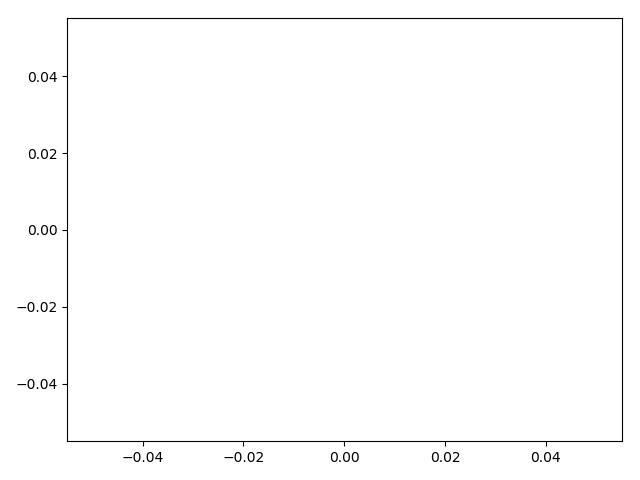

In [5]:
class Net(nn.Module):
    
    
    def __init__(self):
        super(Net, self).__init__()
        self.LSTM = nn.LSTM(voc_size, 50, 2)
        self.dropout = nn.Dropout(p=0.25)
        self.linear = nn.Linear(text_dataloader.batch_size * 600, text_dataloader.batch_size * voc_size)
        self.hidden = nn.Parameter(torch.randn(2, text_dataloader.batch_size, 50, requires_grad=True).cuda())
        self.cell = nn.Parameter(torch.randn(2, text_dataloader.batch_size, 50, requires_grad=True).cuda())
    
    def forward(self, x):
        x, (_, _) = self.LSTM(x, (self.hidden, self.cell))
        x = self.dropout(x)
        #x = x.transpose(0, 1).contiguous()
        x = self.linear(x.view(-1))
        x = x.view(text_dataloader.batch_size, -1)
        return x
            

net = Net().cuda()
net.train()
net.load_state_dict(torch.load('/home/max/text_generation_with_rnn/Ed_Sheeran_lyrics_gen_dropout_0.25.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)


loss_history = []
loss_iter_history = []
loss_curr_iter = 0

f, loss_axis = plt.subplots(1,1)
loss_axis.plot(loss_history, loss_iter_history, 'r')

plt.tight_layout()